In [3]:
import networkx as nx
import gurobipy as gb
from itertools import combinations, chain
import pygraphviz as pygv
import random 

import os
from IPython.display import SVG, display
import matplotlib.pyplot as plt

# The only problem is that doesen't work, but had no time left :'(

In [36]:
def draw(G, node_color, edge_color, pos):
    node_lab = {i for i in G.nodes()}
    plt.figure(figsize=(4,4))
    nx.draw(G, pos, with_labels=True, node_color=node_color, edge_color=edge_color, node_size=500)
    plt.show()

class args:
    filename = None
    scale = 40
    figsize = (5,5)
    
def DrawSol(G, f, K):
    for k in K: 
        plt.figure(figsize=args.figsize)
        plt.title("path of commodity " + str(k))
        pos = nx.shell_layout(G)

        nx.draw_networkx_nodes(G, pos=pos, node_shape='o', node_size=600, node_color='lightblue', label=[G.nodes()])
        nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)


        color = ['#%06X' % random.randint(0, 0xFFFFFF) for i in K]
        all_sol_edges = []

        edges_in_sol = []
        for u,v in G.edges():
            if f[u,v,k].x > 0.01:
                edges_in_sol.append((u,v))
            if f[v,u,k].x > 0.01:
                edges_in_sol.append((v,u))



        for u,v in G.edges():
            if((u,v) not in all_sol_edges):
                nx.draw_networkx_edges(G, pos=pos, edgelist=[(u,v)], edge_color='darkgrey')   

        for u,v in edges_in_sol:
            nx.draw_networkx_edges(G, pos=pos, edgelist=[(u,v)], edge_color=color[k])   
        plt.axis('off')
        plt.show()

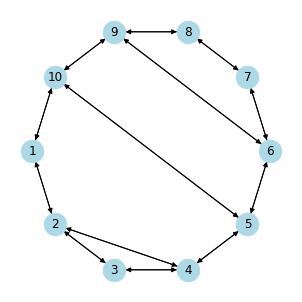

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1078 rows, 584 columns and 2808 nonzeros
Model fingerprint: 0xb45fbee6
Model has 61 quadratic constraints
Variable types: 90 continuous, 494 integer (494 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
  QRHS range       [1e+00, 1e+00]
Presolve removed 925 rows and 121 columns
Presolve time: 0.09s
Presolved: 630 rows, 697 columns, 2102 nonzeros
Variable types: 10 continuous, 687 integer (687 binary)

Root relaxation: objective 9.000000e+00, 28 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       9.0000000    9.00000  0.00%  

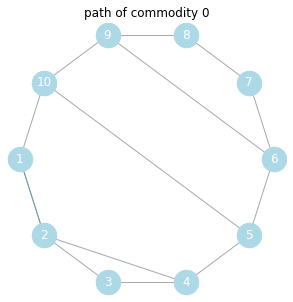

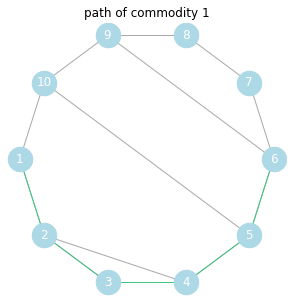

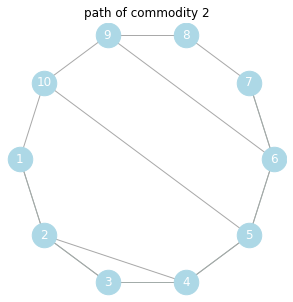

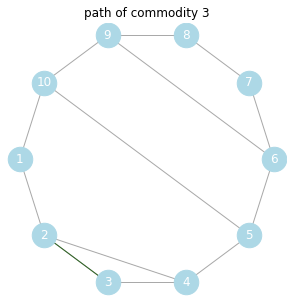

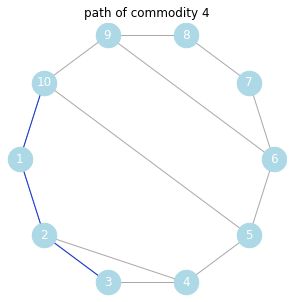

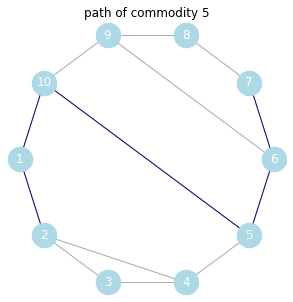

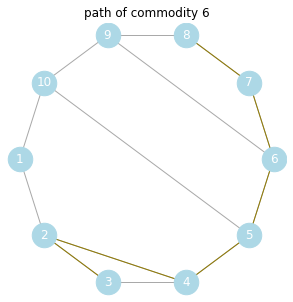

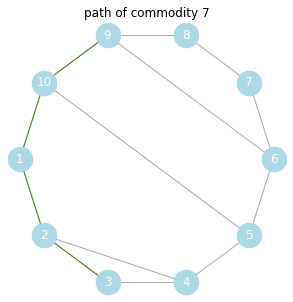

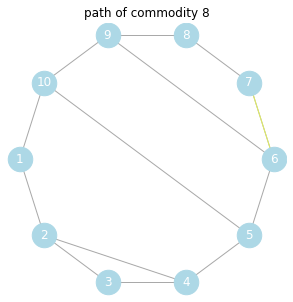

<gurobi.Var x[10,1] (value 1.0)>
<gurobi.Var x[3,2] (value 1.0)>
<gurobi.Var x[4,2] (value 1.0)>
<gurobi.Var x[3,2] (value 1.0)>
<gurobi.Var x[3,4] (value 1.0)>
<gurobi.Var x[3,4] (value 1.0)>
<gurobi.Var x[4,2] (value 1.0)>
<gurobi.Var x[6,5] (value 1.0)>
<gurobi.Var x[6,5] (value 1.0)>
<gurobi.Var x[7,6] (value 1.0)>
<gurobi.Var x[9,6] (value 1.0)>
<gurobi.Var x[7,6] (value 1.0)>
<gurobi.Var x[7,8] (value 1.0)>
<gurobi.Var x[7,8] (value 1.0)>
<gurobi.Var x[10,9] (value 1.0)>
<gurobi.Var x[9,6] (value 1.0)>
<gurobi.Var x[10,9] (value 1.0)>
<gurobi.Var x[10,1] (value 1.0)>


In [52]:
G = nx.cycle_graph([i for i in range(1, 11)])
G.add_edges_from([(2,4), (5,10), (6,9)])
G = G.to_directed()
draw(G, "lightblue", "black", nx.shell_layout(G))

ST = [(1,2), (1,6), (1,7), (2,3), (3,10), (2,7), (3,8), (3,9), (7,6), (9,2)] 
K = [i for i in range(len(ST[:-1]))]
B = [1, 2, 1, 1, 3, 2, 1, 1, 1, 2]
capacity = 6

multi = gb.Model()

x = multi.addVars(G.edges(), vtype=gb.GRB.BINARY, name='x')
y = multi.addVars(G.edges(), K, vtype=gb.GRB.BINARY, name='y')
q = multi.addVars(G.nodes(), K, vtype=gb.GRB.CONTINUOUS, name='q')
f = multi.addVars(G.edges(), K, vtype=gb.GRB.BINARY, name='f')

multi.setObjective(x.sum())

# Balance constraint  
for v in G.nodes():
    for k in K:
        if v == ST[k][0]:
            multi.addConstr(f.sum('*',v,k) - f.sum(v,'*',k) == -1)
        elif v == ST[k][1]:
            multi.addConstr(f.sum('*',v,k) - f.sum(v,'*',k) == 1)
        else: 
            multi.addConstr(f.sum('*',v,k) - f.sum(v,'*',k) == 0)
all_edges = []
for i,j in G.edges():
    all_edges.append((i,j))
    all_edges.append((j,i))
    
for i,j in all_edges:
    multi.addConstr(gb.quicksum(f[i,j,k]*B[k] for k in K) <= capacity) # Capacity Constraint
    multi.addConstr(gb.quicksum(x[i,j]*y[i,j,k] for k in K) <= 1) 

    for k in K:
        multi.addConstr(f[i,j,k] >= 0)
        multi.addConstr(q[j,k] >= q[i,k] + 1 - len(G.nodes()) * (1 - x[i,j]))
for k in K:
    multi.addConstr(gb.quicksum(x[i,j]*y[i,j,k] for i,j in all_edges) >= 1)

multi.update()
multi.write("asd.lp")
multi.optimize()
print(multi.objval)

G = G.to_undirected()
DrawSol(G, f, K)

for u,v in all_edges:
    if x[u,v].x > 0.0:
        print(x[u,v])